In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pytz
import numpy as np
import matplotlib.dates as mdates
import os
#from smsapi import id_smsapi, pw_smsapi
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Goal get the X last days of data (1 is current day, 2 is today and yesterday)
data_collection_day = 3
# Check if data already exists locally
data_collection_check_local = True

data_folder = "../../data"

In [3]:
columns = {
    'Biomass',
    'Fossil Brown coal/Lignite',
    'Fossil Coal-derived gas',
    'Fossil Gas',
    'Fossil Hard coal',
    'Fossil Oil',
    'Fossil Oil shale',
    'Fossil Peat',
    'Geothermal',
    'Hydro Pumped Storage',
    'Hydro Pumped Storage.1',
    'Hydro Run-of-river and poundage',
    'Hydro Water Reservoir',
    'Marine',
    'Nuclear',
    'Other',
    'Other renewable',
    'Solar',
    'Waste',
    'Wind Offshore',
    'Wind Onshore'
}
line_styles = ['-', '--', '-.', ':']

# Check local data

In [4]:
# Get the current date
current_date = datetime.today().date()

# List to store formatted dates
formatted_dates = []

# Format and add the current date to the list
formatted_dates.append(current_date.strftime("%d.%m.%Y"))

# Loop through the previous days and add them to the list
for i in range(1, data_collection_day):
    previous_date = current_date - timedelta(days=i)
    formatted_dates.append(previous_date.strftime("%d.%m.%Y"))

# print(formatted_dates)


# Check if the file exists
newFile = False
if not os.path.exists(data_folder+"/carbon_footprint_data.csv"):
    # If the file doesn't exist, create it
    with open(data_folder+"/carbon_footprint_data.csv", 'w') as f:
        pass  # This creates an empty file

    print(f"File does not exist, no local data available, carbon_footprint_data.csv created successfully.")
    dates_not_in_dataframe = formatted_dates
    newFile = True
else:
    print(f"File already exists, skipping file creation.")


    df_data = pd.read_csv(data_folder+"/carbon_footprint_data.csv", header=0, sep=";")
    
    # List to store dates not in the DataFrame
    dates_not_in_dataframe = []

    # Check if DataFrame has data
    if not df_data.empty:
        df_data['start_datetime'] = pd.to_datetime(df_data['start_datetime'])

        
        current_date_cest = datetime.now().date()
        # print(current_date_cest)

        # Delete all data from today
        df_data = df_data[df_data['start_datetime'].dt.date != current_date_cest]
        df_data.reset_index(drop=True, inplace=True)
        
        # Iterate through formatted dates
        for date in formatted_dates:
            # Check if the date exists in the DataFrame
            if not df_data['start_datetime'].dt.strftime("%d.%m.%Y").isin([date]).any():
                dates_not_in_dataframe.append(date)
            else:
                local_df = df_data[df_data['start_datetime'].dt.strftime("%d.%m.%Y") == date]

                # Counting NaN values in each column
                nan_counts = local_df.isna().sum()

                # Counting columns with NaN values
                columns_with_nan = nan_counts[nan_counts > 0].count()
                # If more than half of the columns have NaN values, add this date to the dates to be downloaded
                if columns_with_nan > (df_data.shape[1]/2):
                    dates_not_in_dataframe.append(date)
                #Remove all data of that date
                df_data = df_data[df_data['start_datetime'].dt.strftime("%d.%m.%Y") != date]
        df_data.to_csv(data_folder+"/carbon_footprint_data.csv", sep=';', header=True,index=False)
    else:
        # If DataFrame is empty, all dates need to be downloaded
        dates_not_in_dataframe = formatted_dates



# Print the dates not in the DataFrame
print("Dates not in the DataFrame:", dates_not_in_dataframe)


File already exists, skipping file creation.
Dates not in the DataFrame: ['17.04.2024', '16.04.2024', '15.04.2024']


# Import data from ENTSOE

Warning! The data of ENTSOE is actualised every day at 14:00 CEST. The server isn't available at this time +- 5 minutes!

https://transparency.entsoe.eu/generation/r2/actualGenerationPerProductionType/show?name=&defaultValue=false&viewType=GRAPH&areaType=CTY&atch=false&datepicker-day-offset-select-dv-date-from_input=D&dateTime.dateTime=04.04.2024%2000:00|CET%7CDAYTIMERANGE&dateTime.endDateTime=04.04.2024%2000:00|CET%7CDAYTIMERANGE&area.values=CTY%7C10Y1001A1001A83F!CTY%7C10Y1001A1001A83F&productionType.values=B01&productionType.values=B02&productionType.values=B03&productionType.values=B04&productionType.values=B05&productionType.values=B06&productionType.values=B07&productionType.values=B08&productionType.values=B09&productionType.values=B10&productionType.values=B11&productionType.values=B12&productionType.values=B13&productionType.values=B14&productionType.values=B20&productionType.values=B15&productionType.values=B16&productionType.values=B17&productionType.values=B18&productionType.values=B19&dateTime.timezone=CET_CEST&dateTime.timezone_input=CET+(UTC+1)+/+CEST+(UTC+2)

In [6]:
for date_to_get in dates_not_in_dataframe:
    date_to_get_object = datetime.strptime(date_to_get, "%d.%m.%Y")

    # URL of the webpage containing the table
    url = f"https://transparency.entsoe.eu/generation/r2/actualGenerationPerProductionType/show?name=&defaultValue=false&viewType=TABLE&areaType=CTY&atch=false&datepicker-day-offset-select-dv-date-from_input=D&dateTime.dateTime={date_to_get}+00:00|CET|DAYTIMERANGE&dateTime.endDateTime={date_to_get}+00:00|CET|DAYTIMERANGE&area.values=CTY|10Y1001A1001A83F!CTY|10Y1001A1001A83F&productionType.values=B01&productionType.values=B02&productionType.values=B03&productionType.values=B04&productionType.values=B05&productionType.values=B06&productionType.values=B07&productionType.values=B08&productionType.values=B09&productionType.values=B10&productionType.values=B11&productionType.values=B12&productionType.values=B13&productionType.values=B14&productionType.values=B20&productionType.values=B15&productionType.values=B16&productionType.values=B17&productionType.values=B18&productionType.values=B19&dateTime.timezone=CET_CEST&dateTime.timezone_input=CET+(UTC+1)+/+CEST+(UTC+2)"
    print(f"Fetching from {url} for day {date_to_get}")
    # Send a GET request to fetch the webpage content
    try:
        response = requests.get(url)

        if response.status_code == 200:
            print("..successful")
        else:
            print("Request failed with status code:", response.status_code)
    except requests.exceptions.RequestException as e:
        print("An error occurred:", e)

    # Parse the HTML content using BeautifulSoup
    soup = BeautifulSoup(response.text, 'html.parser')

    # Find all tables in the HTML
    tables = soup.find_all('table')

    # Iterate through each table to find the one containing "Biomass"
    target_table = None
    for table in tables:
        if "Biomass" in table.get_text():
            target_table = table
            break

    if target_table:
        # Convert the HTML table to a pandas DataFrame
        df = pd.read_html(str(target_table))[0]
        # Replace "n/e" with NaN
        df.replace('-', np.nan, inplace=True)
        df.replace('n/e', np.nan, inplace=True)

        # Print the DataFrame
        # print(df)
        df.to_csv("tempdata.csv", sep=';', header=True,index=False)
        
    else:
        #HIER ERROR EINFÜGEN
        print("No table containing 'Biomass' found on the webpage.")

    df = pd.read_csv("tempdata.csv", sep=";",header=1)
    df = df.iloc[3:]
    # Reset the index after dropping rows
    df.reset_index(drop=True, inplace=True)
    columns_to_convert = [col for col in df.columns if col != 'MTU']
    df[columns_to_convert] = df[columns_to_convert].astype(float)
    df[['start', 'end']] = df['MTU'].str.split(' - ', expand=True)


    # Get the current date and time in CET timezone
    current_datetime_cet = datetime.now(pytz.timezone('Europe/Paris'))

    # Extract the date part

    # Convert the "start" column to datetime format with the current date
    df['start_datetime'] = pd.to_datetime(date_to_get_object.strftime("%Y-%m-%d") + ' ' + df['start'])
    df['start_datetime'] = df['start_datetime'].dt.tz_localize('Europe/Paris')

    # Convert the datetime to Unix timestamp
    df['start_unix_timestamp'] = df['start_datetime'].astype(int) / 10**9  # Convert nanoseconds to seconds

    # Convert the "start" column to datetime format with the current date
    df['end_datetime'] = pd.to_datetime(date_to_get_object.strftime("%Y-%m-%d") + ' ' + df['end'])
    df['end_datetime'] = df['end_datetime'].dt.tz_localize('Europe/Paris')

    # Convert the datetime to Unix timestamp
    df['end_unix_timestamp'] = df['end_datetime'].astype(int) / 10**9  # Convert nanoseconds to seconds
    # print(df)
    if newFile:
        df.to_csv(data_folder+"/carbon_footprint_data.csv", sep=';', header=True,index=False)
        newFile = False
    else:
        df.to_csv(data_folder+"/carbon_footprint_data.csv", sep=';', header=False,index=False, mode='a')
    

Fetching from https://transparency.entsoe.eu/generation/r2/actualGenerationPerProductionType/show?name=&defaultValue=false&viewType=TABLE&areaType=CTY&atch=false&datepicker-day-offset-select-dv-date-from_input=D&dateTime.dateTime=17.04.2024+00:00|CET|DAYTIMERANGE&dateTime.endDateTime=17.04.2024+00:00|CET|DAYTIMERANGE&area.values=CTY|10Y1001A1001A83F!CTY|10Y1001A1001A83F&productionType.values=B01&productionType.values=B02&productionType.values=B03&productionType.values=B04&productionType.values=B05&productionType.values=B06&productionType.values=B07&productionType.values=B08&productionType.values=B09&productionType.values=B10&productionType.values=B11&productionType.values=B12&productionType.values=B13&productionType.values=B14&productionType.values=B20&productionType.values=B15&productionType.values=B16&productionType.values=B17&productionType.values=B18&productionType.values=B19&dateTime.timezone=CET_CEST&dateTime.timezone_input=CET+(UTC+1)+/+CEST+(UTC+2) for day 17.04.2024
..successf

In [ ]:
columns = {
    'Biomass',
    'Fossil Brown coal/Lignite',
    'Fossil Coal-derived gas',
    'Fossil Gas',
    'Fossil Hard coal',
    'Fossil Oil',
    'Fossil Oil shale',
    'Fossil Peat',
    'Geothermal',
    'Hydro Pumped Storage',
    'Hydro Pumped Storage.1',
    'Hydro Run-of-river and poundage',
    'Hydro Water Reservoir',
    'Marine',
    'Nuclear',
    'Other',
    'Other renewable',
    'Solar',
    'Waste',
    'Wind Offshore',
    'Wind Onshore'
}
line_styles = ['-', '--', '-.', ':']

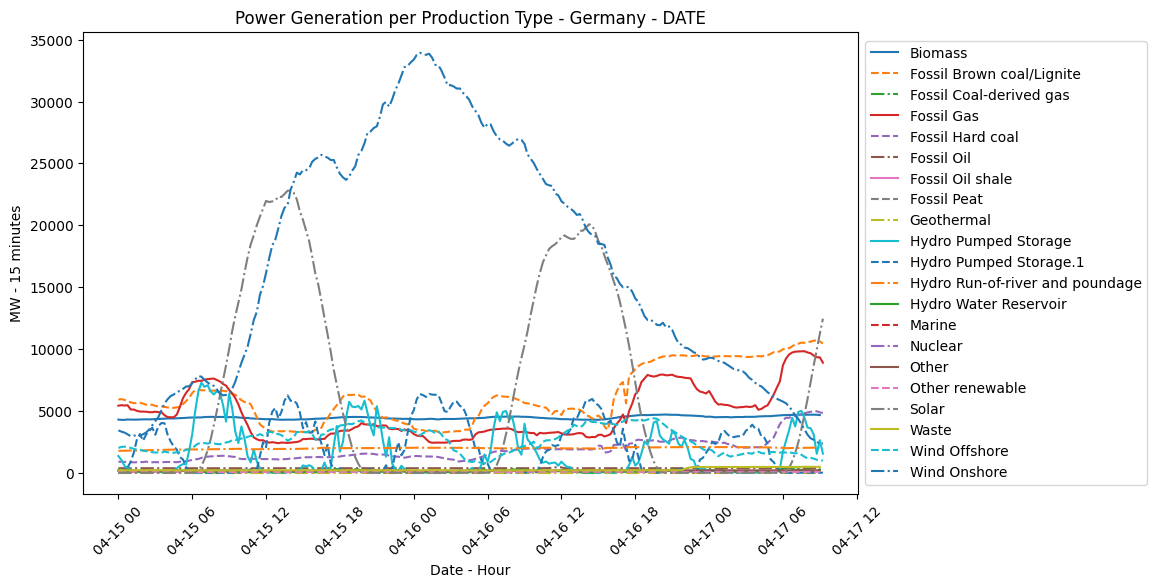

In [ ]:
df_data = pd.read_csv(data_folder+"/carbon_footprint_data.csv", header=0, sep=";")

df_data['start_datetime'] = pd.to_datetime(df_data['start_datetime'])
df_data['end_datetime'] = pd.to_datetime(df_data['end_datetime'])

df_data= df_data.sort_values(by='start_datetime', ascending=True)

# Plotting
plt.figure(figsize=(10, 6))

for i, column in enumerate(sorted(columns)):
    plt.plot(df_data['start_datetime'], df_data[f'{column}'], label=f'{column}', linestyle=line_styles[i%3])
plt.xlabel('Date - Hour')
plt.ylabel('MW - 15 minutes')
plt.title(f'Power Generation per Production Type - Germany - DATE')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Rotate the x-axis labels for better readability (optional)
plt.xticks(rotation=45)

plt.show()

# CO2 Äquivalente

https://www.umweltbundesamt.de/sites/default/files/medien/1410/publikationen/2023_05_23_climate_change_20-2023_strommix_bf.pdf

In [ ]:
#  CO2 Produktion in gr/kWh
# BITTE ZAHLEN NOCHMAL ÜBERPRÜFEN

co2_dict= {
    'Biomass': 230,
    'Fossil Brown coal/Lignite': 1137,
    'Fossil Coal-derived gas': 650,
    'Fossil Gas': 381,
    'Fossil Hard coal': 853,
    'Fossil Oil': 859,
    'Fossil Oil shale': 800,
    'Fossil Peat': 800,
    'Geothermal': 38,
    'Hydro Pumped Storage': 32,
    'Hydro Pumped Storage.1': 32,
    'Hydro Run-of-river and poundage': 32,
    'Hydro Water Reservoir': 32,
    'Marine': 24,
    'Nuclear': 11,
    'Other': 200,
    'Other renewable': 25,
    'Solar': 143,
    'Waste': 350,
    'Wind Offshore': 4,
    'Wind Onshore': 7
}


CO2 Äquivalente Tabelle berechnen

In [ ]:
# co2 dict ist in gr/kWh
# df[energy source] ist in MW pro viertelstunde
#  Umrechnung: df[energy_source]/4 -> MWh 
#  df[energy_source]/4*1000 -> kWh


for energy_source, co2_emission in co2_dict.items():
    df_data[f"{energy_source}_co2"] = df_data[energy_source]/4*1000 * co2_emission

df_data['totalEnergy_MWh'] = df_data[list(columns)].sum(axis=1)# still in MW pro 15 minutes
df_data['totalEnergy_MWh'] = df_data['totalEnergy_MWh']/4# now in MWh
columns_to_sum_co2 = [column + '_co2' for column in columns]
df_data['totalCO2_gr'] = df_data[columns_to_sum_co2].sum(axis=1)
df_data['emission_gr_kWh'] = round(df_data['totalCO2_gr'] / (df_data['totalEnergy_MWh']*1000),3) # gr / MWh*1000 -> gr/kWh

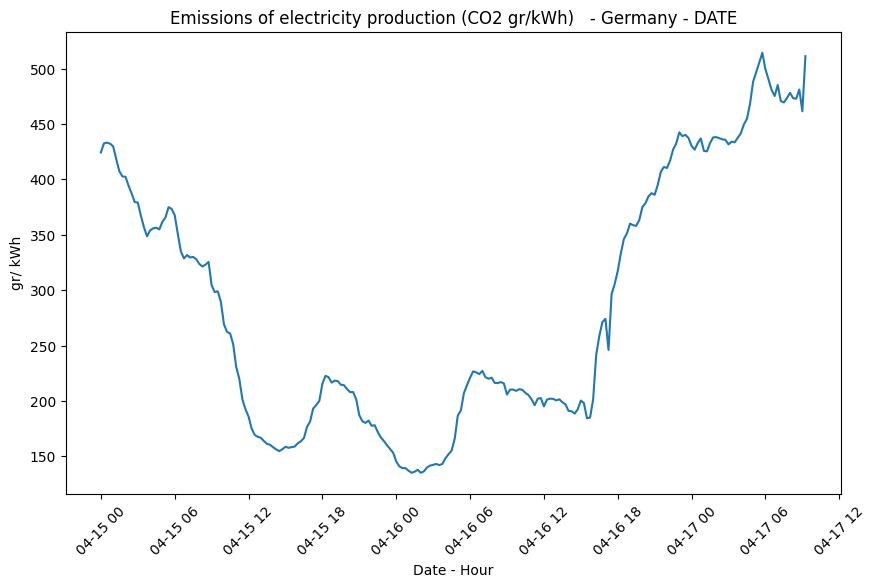

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))


plt.plot(df_data['start_datetime'], df_data["emission_gr_kWh"], label="emission_gr_kWh")
plt.xlabel('Date - Hour')
plt.ylabel('gr/ kWh')
plt.title(f'Emissions of electricity production (CO2 gr/kWh)   - Germany - DATE')

# Rotate the x-axis labels for better readability (optional)
plt.xticks(rotation=45)

plt.show()

In [ ]:
df_data.to_csv(data_folder+"/carbon_footprint_data.csv", sep=';', header=True,index=False)